In [12]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json

In [81]:
image_path = r"../../dataset/coco_2017/val2017/000000000724.jpg"
# imaage_path = r"/home/kaifalam/InPainting_Kaif/dataset/coco_2017/val2017/000000000632.jpg"
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0)
eg_no = 4
# save image as png
image.save(f"eg_img_{eg_no}.png")

In [82]:
image_tensor.size()

torch.Size([1, 3, 500, 375])

In [83]:
model = maskrcnn_resnet50_fpn(pretrained=True).eval()

/home/kaifalam/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kaifalam/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
with torch.no_grad():
    outputs = model(image_tensor)

In [85]:
outputs[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [86]:
outputs[0]['labels'], outputs[0]['scores']

(tensor([13, 13,  8,  3,  8,  8, 19,  7, 28,  3,  3,  3,  3,  8]),
 tensor([0.9997, 0.9955, 0.9872, 0.5427, 0.3461, 0.1622, 0.1466, 0.1218, 0.1166,
         0.1028, 0.0975, 0.0924, 0.0905, 0.0646]))

In [87]:
image_np = np.array(image)
idx_to_label = json.load(open("annotations/coco_category_mapping.json"))
label_to_idx = {v: k for k, v in idx_to_label.items()}

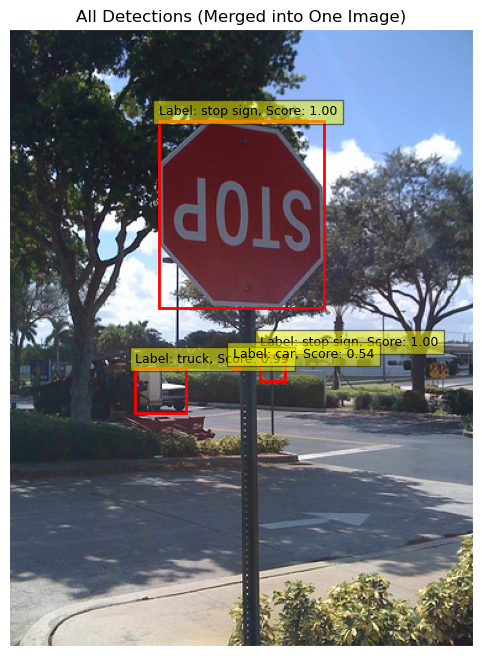

In [88]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_np)

# Loop and draw all boxes + labels on the same image
for i in range(len(outputs[0]['scores'])):
    score = outputs[0]['scores'][i].item()
    if score < 0.5:
        continue

    idx = outputs[0]['labels'][i].item()
    label = idx_to_label[str(idx)]
    box = outputs[0]['boxes'][i].cpu().numpy()
    x1, y1, x2, y2 = box

    # Draw bounding box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Add label + score text
    ax.text(x1, y1 - 5,
            f"Label: {label}, Score: {score:.2f}",
            bbox=dict(facecolor='yellow', alpha=0.5),
            fontsize=9, color='black')

# Hide axes and display
plt.axis('off')
plt.title("All Detections (Merged into One Image)")
plt.show()

Detecting stop sign with index 13


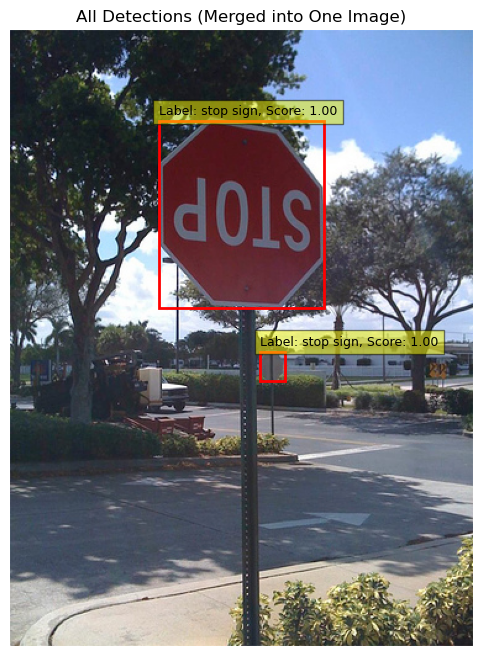

In [89]:
detect_label = 'stop sign'
detect_idx = int(label_to_idx[detect_label])
print(f"Detecting {detect_label} with index {detect_idx}")
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_np)

# Loop and draw all boxes + labels on the same image
for i in range(len(outputs[0]['scores'])):
    score = outputs[0]['scores'][i].item()
    idx = outputs[0]['labels'][i].item()
    if score < 0.5 or idx != detect_idx:
        # print(f"Skipping index {idx} with score {score:.2f}")
        continue
    # print(f"Detected {detect_label} with score {score:.2f}")
    
    label = idx_to_label[str(idx)]
    box = outputs[0]['boxes'][i].cpu().numpy()
    x1, y1, x2, y2 = box

    # Draw bounding box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Add label + score text
    ax.text(x1, y1 - 5,
            f"Label: {label}, Score: {score:.2f}",
            bbox=dict(facecolor='yellow', alpha=0.5),
            fontsize=9, color='black')

# Hide axes and display
plt.axis('off')
plt.title("All Detections (Merged into One Image)")
plt.show()

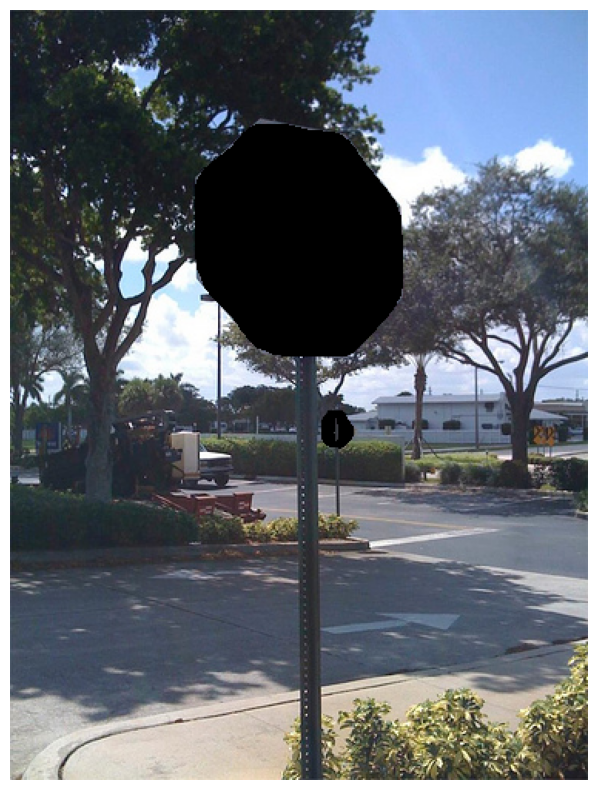

In [90]:
# detect_label = 'chair'
detect_idx = int(label_to_idx[detect_label])
image_np = np.array(image).copy()  # Original image as NumPy array (H, W, 3)

# Loop through detections
for i in range(len(outputs[0]['scores'])):
    if outputs[0]['scores'][i] > 0.5 and outputs[0]['labels'][i].item() == detect_idx:
        # Get binary mask for the object
        mask = outputs[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
        binary_mask = mask > 127  # Convert to boolean

        # Set masked region to black
        image_np[binary_mask] = [0, 0, 0]

# Show the edited image
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
# plt.title(f"Masked Object Label {detect_label} as Black")
plt.show()

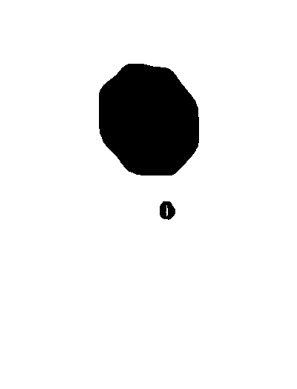

In [91]:
# detect_label = 'chair'
detect_idx = int(label_to_idx[detect_label])
# create a copy of the original image with all white background
image_np = np.array(image).copy()  # Original image as NumPy array (H, W, 3)
image_np.fill(255)  # Set all pixels to white
for i in range(len(outputs[0]['scores'])):
    if outputs[0]['scores'][i] > 0.5 and outputs[0]['labels'][i].item() == detect_idx:
        mask = outputs[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
        binary_mask = mask > 127
        # set masked region to black and rest white
        image_np[binary_mask] = [0, 0, 0]
        # image_np[~binary_mask] = [255, 255, 255]
        # plt.imshow(mask, cmap='gray')
        # plt.title(f"Label: {outputs[0]['labels'][i].item()}, Score: {outputs[0]['scores'][i]:.2f}")
plt.imshow(image_np)
plt.savefig(f"eg_img_{eg_no}_masked_1.png", bbox_inches='tight', pad_inches=0)
plt.axis('off')
plt.show()

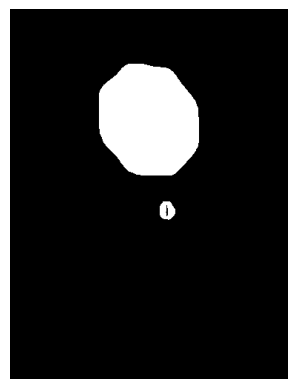

In [92]:
# detect_label = 'chair'
detect_idx = int(label_to_idx[detect_label])
# create a copy of the original image with all white background
image_np = np.array(image).copy()  # Original image as NumPy array (H, W, 3)
image_np.fill(0)  # Set all pixels to white
for i in range(len(outputs[0]['scores'])):
    if outputs[0]['scores'][i] > 0.5 and outputs[0]['labels'][i].item() == detect_idx:
        mask = outputs[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
        binary_mask = mask > 127
        # set masked region to white and rest black
        image_np[binary_mask] = [255, 255, 255]
        
plt.imshow(image_np)
plt.axis('off')
plt.savefig(f"eg_img_{eg_no}_masked_2.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [46]:
mask_t = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
mask_t.shape

(483, 640, 1)

(483, 640, 3)


Text(0.5, 1.0, 'Masked Output for Label 65')

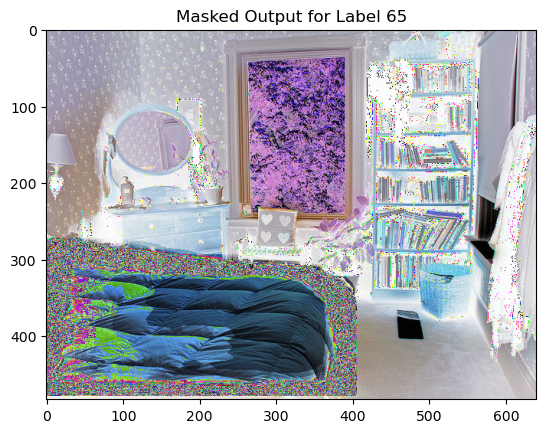

In [62]:
masked_outputs = image_np * mask_t
print(masked_outputs.shape)
plt.imshow(masked_outputs.astype(np.uint8))
plt.title(f"Masked Output for Label {detect_label}")

In [68]:
import shutil

# Copy the original image
shutil.copy(image_path, "../imgs/eg_img_1.jpg")

# Save the masked image (assuming image_np is the masked NumPy array)
from PIL import Image

masked_img = Image.fromarray(image_np.astype(np.uint8))
masked_img.save("../imgs/eg_img_1_masked.jpg")

## Model Testing

In [13]:
from object_detection import tvision_rcnn
model = tvision_rcnn(
    model_name="maskrcnn_resnet50_fpn",
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

In [14]:
img_path = "egs/000000000724.jpg"
image = Image.open(img_path).convert("RGB")

In [15]:
model.get_masked_image(image, detect_label=['stop sign'])

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>